In [131]:
import pandas as pd
import numpy as np
import latent_variable_models.autoencoder.sklearn_ae as ae
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_path = 'data/seurat/seurat_preprocessed.csv'
top_2000_path = 'data/seurat/top_2000.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

We load the preprocessed Seurat Data. We analyze the dataset of the Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics -- see the [Seurat tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html). The data is already preprocessed according to a selection and filtration procedure of cells based on QC metrics. Furthermore, data has been normalized and scaled.

In [2]:
# read preprocessed data
df = pd.read_csv(data_path, index_col=0)
# read top 2000 with the greates variance
top_2000_genes = pd.read_csv(top_2000_path, index_col=0)
# selecting the the top 2000 genes
train = df.loc[top_2000_genes.x.values].values.T

In [3]:
df.head()

,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,...,TTTCAGTGTCACGA-1,TTTCAGTGTCTATC-1,TTTCAGTGTGCAGT-1,TTTCCAGAGGTGAG-1,TTTCGAACACCTGA-1,TTTCGAACTCTCAT-1,TTTCTACTGAGGCA-1,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
AL627309.1,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,...,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123
AP006222.2,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,...,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576
RP11-206L10.2,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,...,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668
RP11-206L10.9,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,...,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646
LINC00115,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,...,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240


In [4]:
train.shape

(2638, 2000)

The gene selection procedure leaves us with a 2000 dimensional feature space. Seurat performs dimension reduction via a PCA. [Seurat tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) suggests an elbow method for detecting the best latent space dimension. Subsequently, a clusters the data, via a hard clustering. The subsequent notebook tackles a improvement of both methods: the dimension reduction, and the clustering. Instead of an PCA with elbow method we analyse various latent variable models. Furthermore, the the clustering in [Seurat tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) is replaced my a [generalized Variational Bayes](https://arxiv.org/abs/1506.03431) approach provided by [STAN](https://mc-stan.org/).

## Bayesian PCA

[Bayesian PCA](https://www.microsoft.com/en-us/research/publication/bayesian-pca/) by Bishop & Tipping does not only perform a dimension reduction but also gets the optimal dimenson by maximising the marginal likelihood.

In [ ]:
from latent_variable_models.ppca.sklearn_ppca import PPCA
latent_model = PPCA(200)
latent_model.fit(train.T)

In [ ]:
X = latent_model.transform(train.T)
pd.DataFrame(X).to_csv('results/ppca/bayesian_pca.csv')

We found the optimal dimension to be $7$ which corresponds pretty well to the outcome we would get from the elbow method in [Seurat tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html).

Load and running the STAN-Model which is an improvement of the [Combat algorithm](https://academic.oup.com/biostatistics/article/8/1/118/252073). Combat adopts the classical Variational Bayes approach where the prior is limited to be the conjugated one of the likelihood. In STAN we can compute Variational Bayes with any likelihood-prior combination. We computed the ELBO for various hidden dimensions and two different models: 
* Gaussian Likelihood model with an Inverse Gamma Prior on the variance and a Gaussaian on the means of the cluster (classical conjugate Prior choice).
* Student-t Likelihood with the same choice of pirors.

In [107]:
elbo_student_t = pd.read_csv('results/ppca/elbo_studentt.csv')
elbo_gaussian = pd.read_csv('results/ppca/elbo_gaussian.csv')

Text(0.5, 1.0, 'Student-t Mixture')

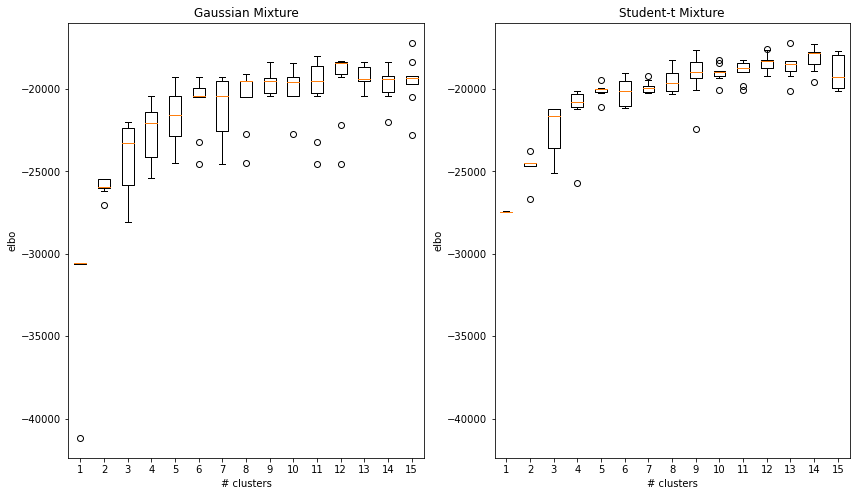

In [124]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(121)
ax.boxplot(elbo_gaussian.values)
ax.set_xlabel('# clusters')
ax.set_ylabel('elbo')
ax.set_title('Gaussian Mixture')
ax = fig.add_subplot(122, sharey=ax)
ax.boxplot(elbo_student_t.values)
ax.set_xlabel('# clusters')
ax.set_ylabel('elbo')
ax.set_title('Student-t Mixture')

Both models have fairly similar performance. In Both cases ELBO saturates beyond 8 or 9 cluster. Incorporating mean value of ELBO and variance in our decision, a Student-t mixture with 10 clusters appears to be a good choice. We compute the class-probabilities for the data-points computed by the Bayesian PCA and plot them using TSNE to project the 7 dimensional data on the 2-dimensional plane. 

In [153]:
# load class-probabilities from the student-t mixture model with 10 clusters
data = pd.read_csv('results/ppca/student-t_10.csv')

# get classes via a naive-bayes classifier
classes = data.apply(lambda x: np.argmax(x), axis=1)

# load data from the Bayesian PCA
X = pd.read_csv('results/ppca/bayesian_pca.csv', index_col=0).T

# perform TSNE onto the 2-dimensional plane for visualization purposes
to_plane = TSNE(2).fit_transform(X.values)

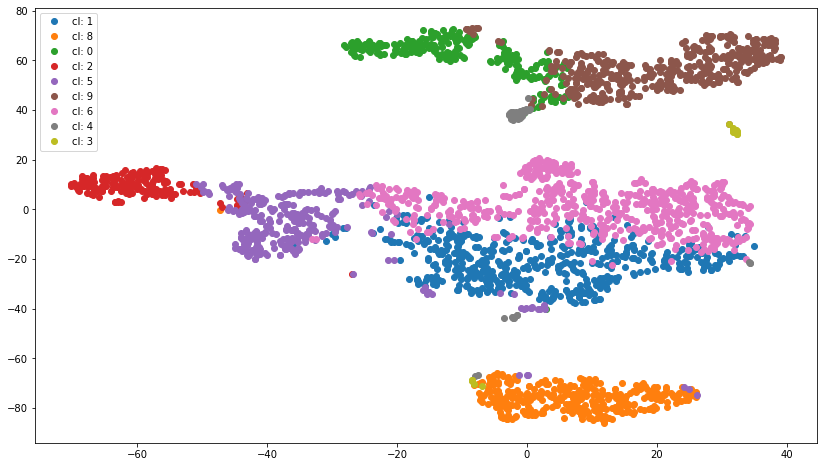

In [166]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
for cl in classes.unique():
    y = to_plane[classes == cl].T
    ax.plot(y[0], y[1], 'o', label=f'cl: {cl}')
ax.legend(loc=0)

## Sparse Autoencoder 

Instead of a Bayesian PCA we take a sparsity Autoencoder

In [69]:
loss_ar = []
for hidden_dim in range(2, 21):
    sparse_ae = ae.SparseAE(hidden_dim=hidden_dim, rate=100.0, epochs=100)
    sparse_ae.fit(train)
    loss_ar.append(sparse_ae.loss())

Epoch 1/100
42/42 [==============================] - 0s 5ms/step - loss: 2880.5115
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 2614.1814
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 2455.9343
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 2355.1199
Epoch 5/100
42/42 [==============================] - 0s 6ms/step - loss: 2314.3494
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 2266.2905
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 2248.2529
Epoch 8/100
42/42 [==============================] - 0s 6ms/step - loss: 2204.5356
Epoch 9/100
42/42 [==============================] - 0s 6ms/step - loss: 2124.7598
Epoch 10/100
42/42 [==============================] - 0s 6ms/step - loss: 2090.8928
Epoch 11/100
42/42 [==============================] - 0s 6ms/step - loss: 2060.2322
Epoch 12/100
42/42 [==============================] - 0s 9ms/step - loss: 2041.6996
E

42/42 [==============================] - 0s 7ms/step - loss: 1735.6266
Epoch 99/100
42/42 [==============================] - 0s 6ms/step - loss: 1734.6791
Epoch 100/100
42/42 [==============================] - 0s 6ms/step - loss: 1729.9401
Epoch 1/100
42/42 [==============================] - 0s 5ms/step - loss: 4350.5591
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 3873.3774: 0s - loss: 387
Epoch 3/100
42/42 [==============================] - 0s 7ms/step - loss: 3659.7476
Epoch 4/100
42/42 [==============================] - 1s 13ms/step - loss: 3514.1956
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 3420.0837
Epoch 6/100
42/42 [==============================] - 0s 10ms/step - loss: 3357.4412
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 3310.3086
Epoch 8/100
42/42 [==============================] - 0s 6ms/step - loss: 3257.1445
Epoch 9/100
42/42 [==============================] - 0s 6ms/step - loss: 3214.

42/42 [==============================] - 0s 6ms/step - loss: 2679.4832
Epoch 96/100
42/42 [==============================] - 0s 5ms/step - loss: 2683.2732
Epoch 97/100
42/42 [==============================] - 0s 6ms/step - loss: 2681.3779
Epoch 98/100
42/42 [==============================] - 0s 6ms/step - loss: 2677.5872
Epoch 99/100
42/42 [==============================] - 1s 14ms/step - loss: 2682.3252
Epoch 100/100
42/42 [==============================] - 1s 16ms/step - loss: 2684.2209
Epoch 1/100
42/42 [==============================] - 0s 9ms/step - loss: 5900.8809
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 5276.6670
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 4971.5820
Epoch 4/100
42/42 [==============================] - 0s 11ms/step - loss: 4754.5024
Epoch 5/100
42/42 [==============================] - 1s 14ms/step - loss: 4603.4756
Epoch 6/100
42/42 [==============================] - 0s 8ms/step - loss: 4526.5068
Epoch 

42/42 [==============================] - 0s 7ms/step - loss: 3796.4233
Epoch 92/100
42/42 [==============================] - 0s 6ms/step - loss: 3791.6853
Epoch 93/100
42/42 [==============================] - 0s 6ms/step - loss: 3780.3132
Epoch 94/100
42/42 [==============================] - 0s 7ms/step - loss: 3783.1555
Epoch 95/100
42/42 [==============================] - 0s 7ms/step - loss: 3787.8943
Epoch 96/100
42/42 [==============================] - 0s 6ms/step - loss: 3792.6331
Epoch 97/100
42/42 [==============================] - 0s 8ms/step - loss: 3788.8420
Epoch 98/100
42/42 [==============================] - 0s 7ms/step - loss: 3787.8943
Epoch 99/100
42/42 [==============================] - 0s 7ms/step - loss: 3798.3188
Epoch 100/100
42/42 [==============================] - 0s 7ms/step - loss: 3795.4758
Epoch 1/100
42/42 [==============================] - 0s 7ms/step - loss: 7330.8062
Epoch 2/100
42/42 [==============================] - 0s 7ms/step - loss: 6628.8613
Epoch 

42/42 [==============================] - 0s 6ms/step - loss: 4375.5747
Epoch 89/100
42/42 [==============================] - 0s 6ms/step - loss: 4367.0449
Epoch 90/100
42/42 [==============================] - 0s 7ms/step - loss: 4376.5225
Epoch 91/100
42/42 [==============================] - 0s 7ms/step - loss: 4367.0449
Epoch 92/100
42/42 [==============================] - 0s 7ms/step - loss: 4358.5161
Epoch 93/100
42/42 [==============================] - 0s 7ms/step - loss: 4364.2021
Epoch 94/100
42/42 [==============================] - 0s 6ms/step - loss: 4362.3062
Epoch 95/100
42/42 [==============================] - 0s 7ms/step - loss: 4372.7314
Epoch 96/100
42/42 [==============================] - 0s 7ms/step - loss: 4363.2539
Epoch 97/100
42/42 [==============================] - 0s 6ms/step - loss: 4369.8882
Epoch 98/100
42/42 [==============================] - 1s 27ms/step - loss: 4369.8887
Epoch 99/100
42/42 [==============================] - 0s 9ms/step - loss: 4362.3062
Epoc

42/42 [==============================] - 0s 7ms/step - loss: 5554.7207
Epoch 85/100
42/42 [==============================] - 0s 6ms/step - loss: 5549.9834
Epoch 86/100
42/42 [==============================] - 0s 6ms/step - loss: 5553.7734
Epoch 87/100
42/42 [==============================] - 0s 6ms/step - loss: 5554.7207
Epoch 88/100
42/42 [==============================] - 0s 6ms/step - loss: 5548.0864
Epoch 89/100
42/42 [==============================] - 0s 6ms/step - loss: 5555.6685
Epoch 90/100
42/42 [==============================] - 0s 6ms/step - loss: 5549.0352
Epoch 91/100
42/42 [==============================] - 0s 6ms/step - loss: 5557.5640
Epoch 92/100
42/42 [==============================] - 0s 7ms/step - loss: 5551.8770
Epoch 93/100
42/42 [==============================] - 0s 6ms/step - loss: 5542.4023
Epoch 94/100
42/42 [==============================] - 0s 6ms/step - loss: 5556.6162
Epoch 95/100
42/42 [==============================] - 0s 6ms/step - loss: 5544.2964
Epoch

42/42 [==============================] - 0s 5ms/step - loss: 5993.2720
Epoch 82/100
42/42 [==============================] - 0s 5ms/step - loss: 5997.0625
Epoch 83/100
42/42 [==============================] - 0s 5ms/step - loss: 6005.5913
Epoch 84/100
42/42 [==============================] - 0s 6ms/step - loss: 6003.6963
Epoch 85/100
42/42 [==============================] - 0s 5ms/step - loss: 6006.5386
Epoch 86/100
42/42 [==============================] - 0s 5ms/step - loss: 5998.9570
Epoch 87/100
42/42 [==============================] - 0s 5ms/step - loss: 6015.0688
Epoch 88/100
42/42 [==============================] - 0s 5ms/step - loss: 5991.3760
Epoch 89/100
42/42 [==============================] - 0s 5ms/step - loss: 6001.8008
Epoch 90/100
42/42 [==============================] - 0s 5ms/step - loss: 5994.2192
Epoch 91/100
42/42 [==============================] - 0s 5ms/step - loss: 5991.3765
Epoch 92/100
42/42 [==============================] - 0s 5ms/step - loss: 6002.7485
Epoch

42/42 [==============================] - 0s 6ms/step - loss: 7193.3447
Epoch 79/100
42/42 [==============================] - 0s 5ms/step - loss: 7199.9795
Epoch 80/100
42/42 [==============================] - 0s 5ms/step - loss: 7217.0381
Epoch 81/100
42/42 [==============================] - 0s 6ms/step - loss: 7204.7173
Epoch 82/100
42/42 [==============================] - 0s 6ms/step - loss: 7189.5532
Epoch 83/100
42/42 [==============================] - 0s 6ms/step - loss: 7202.8218
Epoch 84/100
42/42 [==============================] - 0s 6ms/step - loss: 7201.8735
Epoch 85/100
42/42 [==============================] - 0s 5ms/step - loss: 7196.1890
Epoch 86/100
42/42 [==============================] - 0s 5ms/step - loss: 7204.7163
Epoch 87/100
42/42 [==============================] - 0s 6ms/step - loss: 7205.6665
Epoch 88/100
42/42 [==============================] - 0s 6ms/step - loss: 7175.3384
Epoch 89/100
42/42 [==============================] - 0s 6ms/step - loss: 7198.0840
Epoch

42/42 [==============================] - 0s 5ms/step - loss: 7513.8159
Epoch 76/100
42/42 [==============================] - 0s 5ms/step - loss: 7499.6021
Epoch 77/100
42/42 [==============================] - 0s 5ms/step - loss: 7513.8164
Epoch 78/100
42/42 [==============================] - 0s 5ms/step - loss: 7514.7651
Epoch 79/100
42/42 [==============================] - 0s 5ms/step - loss: 7489.1768
Epoch 80/100
42/42 [==============================] - 0s 5ms/step - loss: 7491.0713
Epoch 81/100
42/42 [==============================] - 0s 4ms/step - loss: 7511.9204
Epoch 82/100
42/42 [==============================] - 0s 5ms/step - loss: 7510.0273
Epoch 83/100
42/42 [==============================] - 0s 5ms/step - loss: 7498.6543
Epoch 84/100
42/42 [==============================] - 0s 5ms/step - loss: 7503.3926
Epoch 85/100
42/42 [==============================] - 0s 5ms/step - loss: 7517.6079
Epoch 86/100
42/42 [==============================] - 0s 5ms/step - loss: 7503.3921
Epoch

42/42 [==============================] - 0s 7ms/step - loss: 8413.5820: 0s - loss: 8505.84
Epoch 73/100
42/42 [==============================] - 0s 8ms/step - loss: 8406.9473: 0s - loss: 8
Epoch 74/100
42/42 [==============================] - 0s 6ms/step - loss: 8403.1562
Epoch 75/100
42/42 [==============================] - 0s 5ms/step - loss: 8414.5293
Epoch 76/100
42/42 [==============================] - 0s 6ms/step - loss: 8387.9941
Epoch 77/100
42/42 [==============================] - 0s 6ms/step - loss: 8405.9990
Epoch 78/100
42/42 [==============================] - 0s 6ms/step - loss: 8403.1572
Epoch 79/100
42/42 [==============================] - 0s 6ms/step - loss: 8401.2598
Epoch 80/100
42/42 [==============================] - 0s 6ms/step - loss: 8392.7334
Epoch 81/100
42/42 [==============================] - 0s 5ms/step - loss: 8405.0518
Epoch 82/100
42/42 [==============================] - 0s 5ms/step - loss: 8398.4180
Epoch 83/100
42/42 [==============================] - 0

42/42 [==============================] - 0s 6ms/step - loss: 9665.5518
Epoch 70/100
42/42 [==============================] - 0s 6ms/step - loss: 9682.6104
Epoch 71/100
42/42 [==============================] - 0s 6ms/step - loss: 9693.9844
Epoch 72/100
42/42 [==============================] - 0s 6ms/step - loss: 9680.7158
Epoch 73/100
42/42 [==============================] - 0s 5ms/step - loss: 9677.8730
Epoch 74/100
42/42 [==============================] - 0s 6ms/step - loss: 9675.0293
Epoch 75/100
42/42 [==============================] - 0s 6ms/step - loss: 9684.5059
Epoch 76/100
42/42 [==============================] - 0s 6ms/step - loss: 9678.8213
Epoch 77/100
42/42 [==============================] - 0s 6ms/step - loss: 9669.3438
Epoch 78/100
42/42 [==============================] - 0s 6ms/step - loss: 9678.8203
Epoch 79/100
42/42 [==============================] - 0s 6ms/step - loss: 9665.5518
Epoch 80/100
42/42 [==============================] - 0s 6ms/step - loss: 9661.7617
Epoch

42/42 [==============================] - 0s 5ms/step - loss: 11131.3584
Epoch 67/100
42/42 [==============================] - 0s 6ms/step - loss: 11130.4111
Epoch 68/100
42/42 [==============================] - 0s 5ms/step - loss: 11141.7822
Epoch 69/100
42/42 [==============================] - 0s 6ms/step - loss: 11118.0898
Epoch 70/100
42/42 [==============================] - 0s 6ms/step - loss: 11138.9404
Epoch 71/100
42/42 [==============================] - 0s 6ms/step - loss: 11115.2490
Epoch 72/100
42/42 [==============================] - 0s 5ms/step - loss: 11149.3643
Epoch 73/100
42/42 [==============================] - 0s 5ms/step - loss: 11130.4121
Epoch 74/100
42/42 [==============================] - 0s 5ms/step - loss: 11147.4688
Epoch 75/100
42/42 [==============================] - 0s 5ms/step - loss: 11136.0957
Epoch 76/100
42/42 [==============================] - 0s 6ms/step - loss: 11125.6719
Epoch 77/100
42/42 [==============================] - 0s 6ms/step - loss: 1112

42/42 [==============================] - 0s 8ms/step - loss: 11998.2666
Epoch 63/100
42/42 [==============================] - 0s 7ms/step - loss: 11974.5742
Epoch 64/100
42/42 [==============================] - 0s 7ms/step - loss: 11938.5615
Epoch 65/100
42/42 [==============================] - 0s 7ms/step - loss: 11976.4697
Epoch 66/100
42/42 [==============================] - 0s 7ms/step - loss: 11976.4697
Epoch 67/100
42/42 [==============================] - 0s 7ms/step - loss: 11994.4736
Epoch 68/100
42/42 [==============================] - 0s 7ms/step - loss: 11987.8398
Epoch 69/100
42/42 [==============================] - 0s 7ms/step - loss: 11972.6816
Epoch 70/100
42/42 [==============================] - 0s 6ms/step - loss: 11956.5674
Epoch 71/100
42/42 [==============================] - 0s 6ms/step - loss: 11962.2549
Epoch 72/100
42/42 [==============================] - 0s 6ms/step - loss: 11948.0391
Epoch 73/100
42/42 [==============================] - 0s 6ms/step - loss: 1193

42/42 [==============================] - 0s 6ms/step - loss: 12789.9648
Epoch 58/100
42/42 [==============================] - 0s 6ms/step - loss: 12756.9609
Epoch 59/100
42/42 [==============================] - 0s 6ms/step - loss: 12755.9678
Epoch 60/100
42/42 [==============================] - 0s 5ms/step - loss: 12739.8652
Epoch 61/100
42/42 [==============================] - 0s 6ms/step - loss: 12752.2393
Epoch 62/100
42/42 [==============================] - 0s 8ms/step - loss: 12754.1045
Epoch 63/100
42/42 [==============================] - 0s 9ms/step - loss: 12733.4434
Epoch 64/100
42/42 [==============================] - 0s 8ms/step - loss: 12727.5479
Epoch 65/100
42/42 [==============================] - 0s 6ms/step - loss: 12764.8066
Epoch 66/100
42/42 [==============================] - 0s 6ms/step - loss: 12716.1172
Epoch 67/100
42/42 [==============================] - 0s 5ms/step - loss: 12734.1230
Epoch 68/100
42/42 [==============================] - 0s 8ms/step - loss: 1270

42/42 [==============================] - 0s 5ms/step - loss: 13957.3223
Epoch 53/100
42/42 [==============================] - 0s 5ms/step - loss: 13954.4775
Epoch 54/100
42/42 [==============================] - 0s 5ms/step - loss: 13948.7949
Epoch 55/100
42/42 [==============================] - 0s 5ms/step - loss: 13967.7471
Epoch 56/100
42/42 [==============================] - 0s 6ms/step - loss: 13926.0488
Epoch 57/100
42/42 [==============================] - 0s 5ms/step - loss: 13899.5117
Epoch 58/100
42/42 [==============================] - 0s 5ms/step - loss: 13952.5840
Epoch 59/100
42/42 [==============================] - 0s 5ms/step - loss: 13974.3789
Epoch 60/100
42/42 [==============================] - 0s 5ms/step - loss: 13943.1064
Epoch 61/100
42/42 [==============================] - 0s 5ms/step - loss: 13959.2158
Epoch 62/100
42/42 [==============================] - 0s 9ms/step - loss: 13954.4766
Epoch 63/100
42/42 [==============================] - 0s 5ms/step - loss: 1393

42/42 [==============================] - 1s 16ms/step - loss: 14607.6787
Epoch 48/100
42/42 [==============================] - 1s 12ms/step - loss: 14526.7129
Epoch 49/100
42/42 [==============================] - 0s 10ms/step - loss: 14528.5537
Epoch 50/100
42/42 [==============================] - 0s 9ms/step - loss: 14545.2920
Epoch 51/100
42/42 [==============================] - 0s 9ms/step - loss: 14542.4551
Epoch 52/100
42/42 [==============================] - 0s 7ms/step - loss: 14526.5840
Epoch 53/100
42/42 [==============================] - 0s 6ms/step - loss: 14526.4531
Epoch 54/100
42/42 [==============================] - 0s 6ms/step - loss: 14463.7314
Epoch 55/100
42/42 [==============================] - 0s 7ms/step - loss: 14472.4629
Epoch 56/100
42/42 [==============================] - 0s 7ms/step - loss: 14479.7910
Epoch 57/100
42/42 [==============================] - 0s 6ms/step - loss: 14518.9854
Epoch 58/100
42/42 [==============================] - 0s 6ms/step - loss: 1

42/42 [==============================] - 0s 6ms/step - loss: 15145.8115
Epoch 43/100
42/42 [==============================] - 0s 6ms/step - loss: 15112.9268
Epoch 44/100
42/42 [==============================] - 0s 6ms/step - loss: 15077.8818
Epoch 45/100
42/42 [==============================] - 0s 6ms/step - loss: 15092.2998
Epoch 46/100
42/42 [==============================] - 0s 6ms/step - loss: 15052.8594
Epoch 47/100
42/42 [==============================] - 0s 6ms/step - loss: 15064.4990
Epoch 48/100
42/42 [==============================] - 0s 6ms/step - loss: 15065.1064
Epoch 49/100
42/42 [==============================] - 0s 6ms/step - loss: 15042.3984
Epoch 50/100
42/42 [==============================] - 0s 6ms/step - loss: 15074.6895
Epoch 51/100
42/42 [==============================] - 0s 7ms/step - loss: 15111.6846
Epoch 52/100
42/42 [==============================] - 0s 8ms/step - loss: 15037.8252
Epoch 53/100
42/42 [==============================] - 0s 7ms/step - loss: 1507

42/42 [==============================] - 0s 6ms/step - loss: 15664.9951
Epoch 39/100
42/42 [==============================] - 0s 7ms/step - loss: 15671.4316
Epoch 40/100
42/42 [==============================] - 0s 6ms/step - loss: 15584.8174
Epoch 41/100
42/42 [==============================] - 0s 6ms/step - loss: 15573.9844
Epoch 42/100
42/42 [==============================] - 0s 7ms/step - loss: 15538.5098
Epoch 43/100
42/42 [==============================] - 0s 8ms/step - loss: 15515.2754
Epoch 44/100
42/42 [==============================] - 0s 6ms/step - loss: 15541.3408
Epoch 45/100
42/42 [==============================] - 0s 5ms/step - loss: 15528.3271
Epoch 46/100
42/42 [==============================] - 0s 5ms/step - loss: 15480.6533
Epoch 47/100
42/42 [==============================] - 0s 9ms/step - loss: 15478.5918
Epoch 48/100
42/42 [==============================] - 0s 6ms/step - loss: 15479.7910
Epoch 49/100
42/42 [==============================] - 0s 5ms/step - loss: 1546

42/42 [==============================] - 0s 6ms/step - loss: 17289.4629
Epoch 34/100
42/42 [==============================] - 0s 5ms/step - loss: 17256.4980
Epoch 35/100
42/42 [==============================] - 0s 7ms/step - loss: 17197.4434
Epoch 36/100
42/42 [==============================] - 0s 6ms/step - loss: 17158.1406
Epoch 37/100
42/42 [==============================] - 0s 5ms/step - loss: 17173.0684
Epoch 38/100
42/42 [==============================] - 0s 6ms/step - loss: 17069.3457
Epoch 39/100
42/42 [==============================] - 0s 6ms/step - loss: 17023.5547
Epoch 40/100
42/42 [==============================] - 0s 6ms/step - loss: 17002.3301
Epoch 41/100
42/42 [==============================] - 0s 5ms/step - loss: 16963.8887
Epoch 42/100
42/42 [==============================] - 0s 6ms/step - loss: 16974.6699
Epoch 43/100
42/42 [==============================] - 0s 7ms/step - loss: 16914.6133
Epoch 44/100
42/42 [==============================] - 0s 6ms/step - loss: 1690

42/42 [==============================] - 0s 6ms/step - loss: 18693.9160
Epoch 29/100
42/42 [==============================] - 0s 5ms/step - loss: 18671.6152
Epoch 30/100
42/42 [==============================] - 0s 6ms/step - loss: 18628.3398
Epoch 31/100
42/42 [==============================] - 0s 6ms/step - loss: 18555.8730
Epoch 32/100
42/42 [==============================] - 0s 5ms/step - loss: 18462.8652
Epoch 33/100
42/42 [==============================] - 0s 5ms/step - loss: 18414.8242
Epoch 34/100
42/42 [==============================] - 0s 7ms/step - loss: 18393.6758
Epoch 35/100
42/42 [==============================] - 1s 13ms/step - loss: 18338.1367: 0s - loss: 18561.24
Epoch 36/100
42/42 [==============================] - 0s 6ms/step - loss: 18282.3809
Epoch 37/100
42/42 [==============================] - 0s 5ms/step - loss: 18207.0000
Epoch 38/100
42/42 [==============================] - 0s 6ms/step - loss: 18159.1367
Epoch 39/100
42/42 [==============================] - 0s

## Denoising Autoencoder

In [86]:
de_ae = ae.DNAE(hidden_dim=10, noise=0.5, epochs=40)